## CLI端部署

在Huggingface Hub上下载baichuan-7B模型，访问网址为：https://huggingface.co/baichuan-inc/Baichuan-7B ,放在GPU机器上的本地路径。

   笔者的GPU机器为4 * RTX6000，每张RTX6000的显存为80G。

   FastChat使用CLI部署百川大模型的命令为：

In [ ]:
python3 -m fastchat.serve.cli --model-path path_of_Baichuan-7B --num-gpus 2

在CLI部署时，如遇到以下的报错：trust_remote_code=True ,参考issue网址：https://github.com/lm-sys/FastChat/issues/1789 ,则在对应的Python路径下，将FastChat的fastchat/model/model_adapter.py文件中的代码中的第57至61行：

In [ ]:
  tokenizer = AutoTokenizer.from_pretrained(
                model_path,
                use_fast=self.use_fast_tokenizer,
                revision=revision,
            )

和69至71行

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
            model_path, low_cpu_mem_usage=True, **from_pretrained_kwargs
        )

中添加代码：`trust_remote_code=True` ,则可顺利部署。

    部署成功后的界面如下：

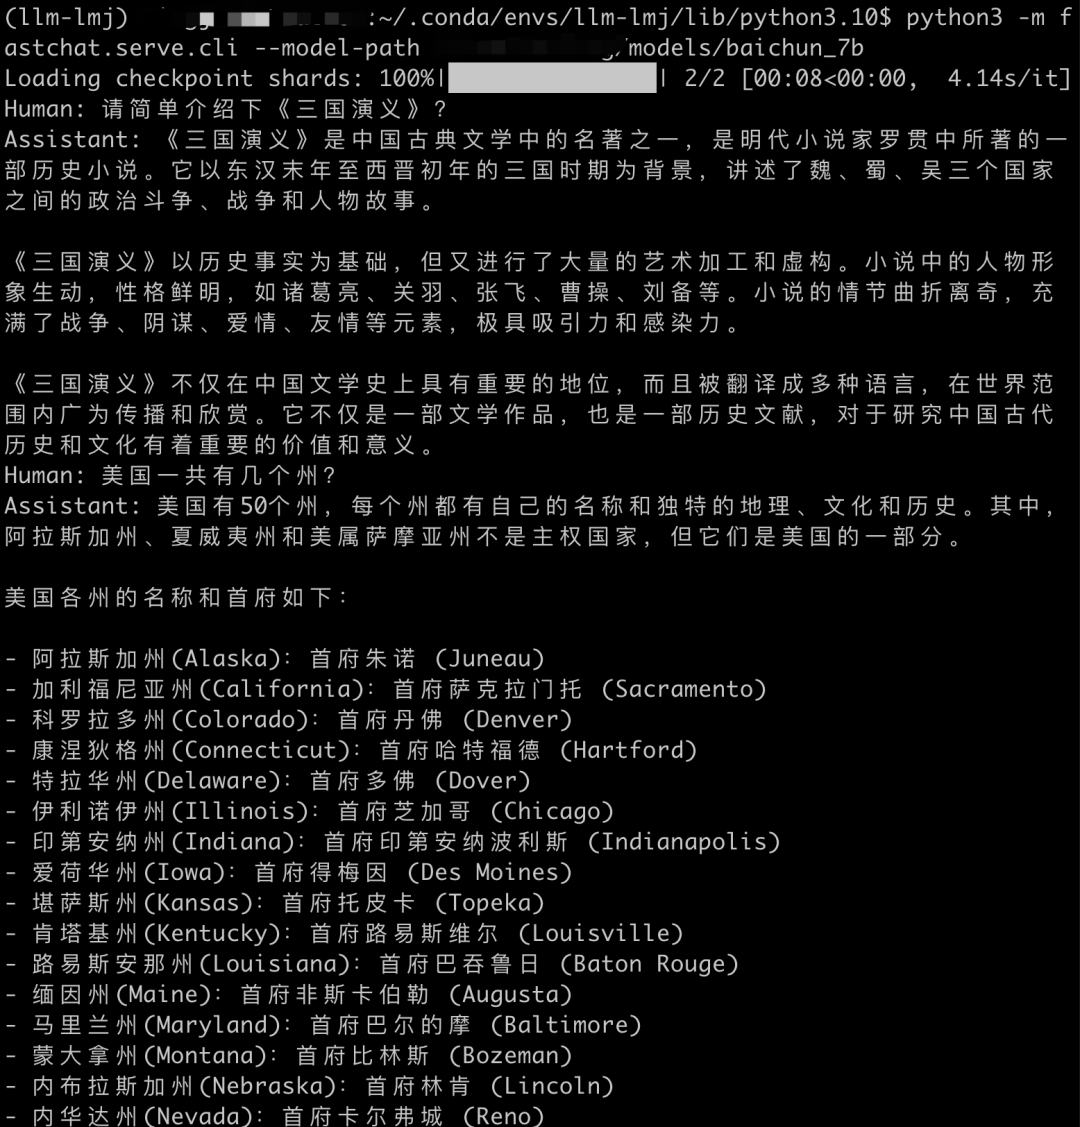

## WEB端部署

FastChat还支持WEB部署，可Web UI和OpenAI兼容的RESTful APIs.  

   这里主要介绍如何实现与OpenAI兼容的具有RESTful APIs的部署方式，参考网址为：https://github.com/lm-sys/FastChat/blob/main/docs/openai_api.md .

   部署一共分为三步：

python3 -m fastchat.serve.controller

python3 -m fastchat.serve.model`worker --model-path path_of_`Baichuan-7B

python3 -m fastchat.serve.openai_api_server --host localhost --port 8000

在部署过程中，如果遇到PydanticImportError ，原因为pydantic版本的问题，只需将pydantic版本降为1.*版本即可。

   部署成功后，该服务可提供与OpenAI风格类似的RESTful APIs，如下：


## 查看模型

curl命令为：

In [ ]:
curl http://localhost:8000/v1/models

In [ ]:
# 输出结果为：

{
  "object": "list",
  "data": [
    {
      "id": "baichun_7b",
      "object": "model",
      "created": 1689004839,
      "owned_by": "fastchat",
      "root": "baichun_7b",
      "parent": null,
      "permission": [
        {
          "id": "modelperm-UERow2kYwq5B2M8aVQkwdk",
          "object": "model_permission",
          "created": 1689004839,
          "allow_create_engine": false,
          "allow_sampling": true,
          "allow_logprobs": true,
          "allow_search_indices": true,
          "allow_view": true,
          "allow_fine_tuning": false,
          "organization": "*",
          "group": null,
          "is_blocking": false
        }
      ]
    }
  ]
}

## 文本补充（Text Completions）

curl命令为：

In [ ]:
curl http://localhost:8000/v1/completions \
  -H "Content-Type: application/json" \
  -d '{
    "model": "baichun_7b",
    "prompt": "Once upon a time",
    "max_tokens": 40,
    "temperature": 0.5
  }' | jq .

In [ ]:
# 输出结果为：

{
  "id": "cmpl-izbe3cRRiY4zAbJueBAyxZ",
  "object": "text_completion",
  "created": 1689004991,
  "model": "baichun_7b",
  "choices": [
    {
      "index": 0,
      "text": ", you could find a variety of different types of chocolate in stores. But now, many chocolate companies are focusing on creating vegan chocolate that is not only delicious but also cruelty-free. Here are",
      "logprobs": null,
      "finish_reason": "length"
    }
  ],
  "usage": {
    "prompt_tokens": 4,
    "total_tokens": 43,
    "completion_tokens": 39
  }
}

## 对话（Chat Completions）

curl命令为：

In [ ]:
curl http://localhost:8000/v1/chat/completions \
  -H "Content-Type: application/json" \
  -d '{
    "model": "baichun_7b",
    "messages": [{"role": "user", "content": "请用中文简单介绍三国演义？"}]
  }' | jq .

In [ ]:
# 输出结果为：

{
  "id": "chatcmpl-3SiRqRgbZR8v6gLnQYo9eJ",
  "object": "chat.completion",
  "created": 1689005219,
  "model": "baichun_7b",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": " 三国演义是中国古代长篇小说，讲述了东汉末年至晋朝初年的历史故事。主要人物包括曹操、刘备、孙权和关羽等。故事情节曲折复杂，涉及政治、军事、文化等多个方面，被誉为中国古代小说的经典之作。《三国演义》不仅是一部文学作品，也是中国文化的重要组成部分，对中国历史和文化产生了深远的影响。"
      },
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 533,
    "total_tokens": 629,
    "completion_tokens": 96
  }
}

## 多轮对话

curl命令为：



In [ ]:
curl http://localhost:8000/v1/chat/completions \
  -H "Content-Type: application/json" \
  -d '{
    "model": "baichun_7b",
    "messages": [{"role": "user", "content": "请用中文简单介绍西游记？"}, {"role": "assistant", "content": "三国演义是中国古代长篇小说，讲述了东汉末年至晋朝初年的历史故事。主要人物包括曹操、刘备、孙权和关羽等。故事情节曲折复杂，涉及政治、军事、文化等多个方面，被誉为中国古代小说的经典之作。《三国演义》不仅是一部文学作品，也是中国文化的重要组成部分，对中国历史和文化产生了深远的影响。"}, {"role": "user", "content": "它的作者是谁？"}]
  }' | jq .

In [ ]:
# 输出结果为：

{
  "id": "chatcmpl-8oE57oXC862wKYyrPLnSGM",
  "object": "chat.completion",
  "created": 1689005374,
  "model": "baichun_7b",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": " 《三国演义》的作者是明代小说家罗贯中。罗贯中是明代文学家，他的代表作品还有《水浒传》和《西游记》等。他在创作《三国演义》时，参考了大量的历史资料和传说，将这些内容融合在一起，创造了一个虚构的世界，成为了中国文学史上的经典之作。"
      },
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 640,
    "total_tokens": 724,
    "completion_tokens": 84
  }
}

## 使用Python代码

In [ ]:
import openai
openai.api_key = "EMPTY" # Not support yet
openai.api_base = "http://localhost:8000/v1"

model = "baichun_7b"
prompt = "Once upon a time"

# create a completion
completion = openai.Completion.create(model=model, prompt=prompt, max_tokens=64)
# print the completion
print(prompt + completion.choices[0].text)

# create a chat completion
completion = openai.ChatCompletion.create(
  model=model,
  messages=[{"role": "user", "content": "Hello! What is your name?"}]
)
# print the completion
print(completion.choices[0].message.content)

以上两种部署方式，都支持流式输出，且模型推理速度较快，笔者在上述测试例子中的推理时间一般为5-7秒，且支持分布式部署，并发量高。